In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
import numpy as np
import duckietown_code_utils as dcu;
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


DEBUG:commons:version: 6.1.7 *
INFO:typing:version: 6.1.8
INFO:conf_tools:conf_tools 6.0.2


Populating the interactive namespace from numpy and matplotlib


# Implementation of Braitenberg agent

Now we know enough to implement our Braitenberg agent.


We will implement an agent of the form

```python
left_motor  = const + gain *  np.sum( LEFT * preprocess(image) )
right_motor = const + gain *  np.sum( RIGHT * preprocess(image) )
```

where `LEFT` and `RIGHT` are the weight matrices, while `const` and `gain` are two extra parameters for fine tuning.

You will have to implement the two functions `get_motor_left_matrix()` and `get_motor_right_matrix()` in the file [connections.py](connections.py). The file contains code that creates connections with some random values. Erase and put your own.

The other important code, which you need to **not** touch (at the beginning), is the file [agent.py](agent.py). This contains the rest of the Braitenberg agent, including all of the functionality (reading observations and create commands). The agent will load the `get_motor_left_matrix`, `get_motor_right_matrix` functions from the file [connections.py](connections.py).


We can also load the functions from this notebook:

In [2]:
from connections import get_motor_left_matrix, get_motor_right_matrix

We can visualize the functions above. As we said, the defaults do not make much sense, so not much interesting. But if you go and change the functions, then you will see more interesting results.

Note: you might need to reload the kernel for the notebook to detect the changes.

In [3]:
fn = '../samples/big-duck/big-duck-10.jpg'
image1 = dcu.rgb_from_jpg_fn(fn);
image1_gray = np.mean(image1, axis=2)
shape = image1_gray.shape

5.6816116e-23 1.0000075
7.4563927e-25 1.0000075


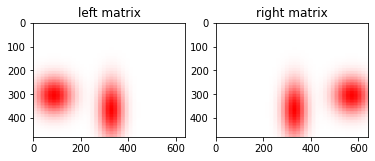

In [13]:
L = get_motor_left_matrix(shape)
R = get_motor_right_matrix(shape)

# visualizing left matrix
print(L.min(), L.max())
print(R.min(), R.max())


f = figure()
f.add_subplot(1, 2, 1)
imshow(dcu.posneg(L))
title('left matrix');
f.add_subplot(1, 2, 2)
imshow(dcu.posneg(R))
title('right matrix');

The following code will run the algorithm against some test images.

Note that it is not possible to really test such an algorithm on passive data. We need to run it!

(480, 640)


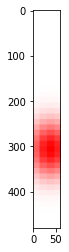

In [72]:
s = L.shape
print(s)
imshow(dcu.posneg(L[:, 290:350]))
imshow(dcu.posneg(L[:, s[1]//8-30:s[1]//8+30]))


fname: ../samples/9970/t0.jpeg, cl: 0.22538426717122395, l: 20298.041015625, r: 8865.162109375, ls: 0.0, rs: 0.0, thingleft: -1.3130611429611842e-05
left: 0.1, right: 0.1
fname: ../samples/9970/t11.jpeg, cl: 0.0, l: 61624.5546875, r: 61314.9453125, ls: 1.0, rs: 1.0, thingleft: 0.0
left: 0.2, right: 0.2
fname: ../samples/9970/t6.jpeg, cl: 1.0351754421657986, l: 38360.9609375, r: 38347.81640625, ls: 0.4370782414720801, rs: 0.562112033574972, thingleft: 4.48224652144644e-06
left: 0.143707824147208, right: 0.15621120335749722
fname: ../samples/9970/front3.jpeg, cl: 15.723111979166667, l: 1092039.5, r: 762776.375, ls: 1.0, rs: 1.0, thingleft: 0.0
left: 0.2, right: 0.2
fname: ../samples/9970/t8.jpeg, cl: 0.9026278347439236, l: 30119.908203125, r: 30424.693359375, ls: 0.009164399776796535, rs: 0.02859691019495128, thingleft: -0.002470124297671848
left: 0.10091643997767966, right: 0.10285969101949513
fname: ../samples/9970/front2.jpeg, cl: 23.928246527777777, l: 1086512.25, r: 1100059.125, ls:

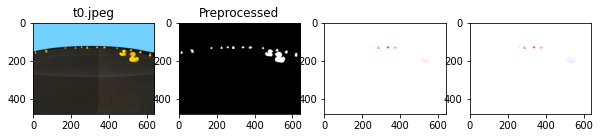

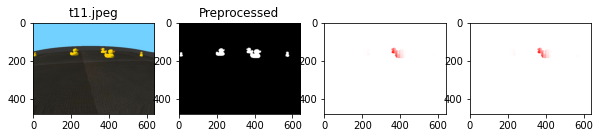

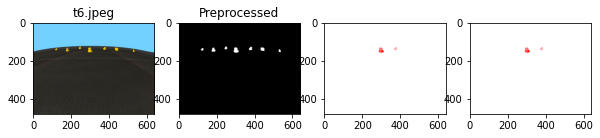

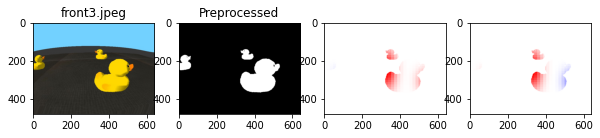

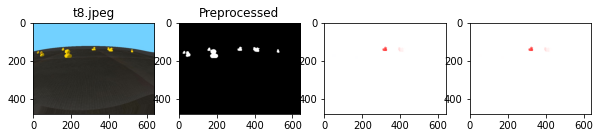

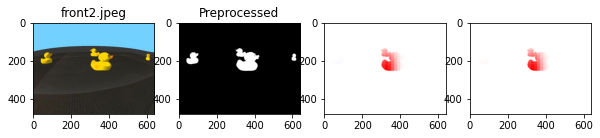

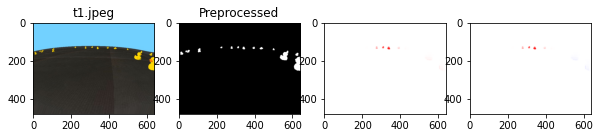

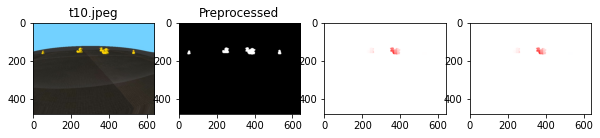

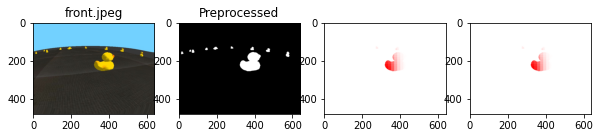

In [55]:
from matplotlib import pylab
import glob, os
import math
from preprocessing import preprocess
dirname = '../samples/9970/'
images = glob.glob(f'{dirname}/*.jpeg')

L = get_motor_left_matrix(shape)
R = get_motor_right_matrix(shape)


def rescale(a: float, L: float, U: float):
    if np.allclose(L, U):
        return 0.0
    return (a - L) / (U - L)

l_max = -math.inf
r_max = -math.inf
l_min = math.inf
r_min = math.inf

for a in images:
    im = dcu.rgb_from_jpg_fn(a)
    P = preprocess(im)
    Lim = P * L
    Rim = P * R
#     Lsign = np.sum(Lim)
#     Rsign = np.sum(Rim)

    # Try agent.py
    l = float(np.sum(P * L))
    r = float(np.sum(P * R))

    # These are big numbers -- we want to normalize them.
    # We normalize them using the history

    # first, we remember the high/low of these raw signals
    l_max = max(l, l_max)
    r_max = max(r, r_max)
    l_min = min(l, l_min)
    r_min = min(r, r_min)

    # now rescale from 0 to 1
    ls = rescale(l, l_min, l_max)
    rs = rescale(r, r_min, r_max)

    gain = 0.1
    const = 0.1
    pwm_left = const + ls * gain
    pwm_right = const + rs * gain

    width = 30
    dim = Lim.shape
    cl = float(np.sum(Lim[:, dim[1]//2-width:dim[1]//2 +width]) / (dim[0]*width*2))
    thingleft  = float(np.sum(Lim[:, dim[1]//4-width:dim[1]//4 +width]) / (dim[0] * width * 2) )      
    
    # print(f'm_left: {left}, m_right: {right}')
    print(f'fname: {a}, cl: {cl}, l: {l}, r: {r}, ls: {ls}, rs: {rs}, thingleft: {thingleft}')
    print(f'left: {pwm_left}, right: {pwm_right}')

    
    f = pylab.figure(figsize=(10,2))
    f.add_subplot(1, 4, 1)
    imshow(im)
    pylab.title(os.path.basename(a))
    f.add_subplot(1, 4, 2)
    imshow(P, cmap='gray')
    pylab.title("Preprocessed")
    f.add_subplot(1, 4, 3)
    imshow(dcu.posneg(Lim))
    #pylab.title('left wheel ' + ('↑' if Lsign > 0 else '↓'))
    f.add_subplot(1, 4, 4)
    imshow(dcu.posneg(Rim), cmap='bwr')
    #pylab.title('right wheel ' + ('↑' if Rsign > 0 else '↓'))


Your agent is now ready to be tested according to the instructions in the [README](https://github.com/duckietown/mooc-exercises/blob/daffy/braitenberg/README.md).

Consider the agent that we gave you as a starting point - feel free to explore with different code also in [agent.py](agent.py).

Remember that to hand in the exercise, you will have to complete the final step in the instructions successfully (`dts challenges submit`).